# PCA mit Logistic Regression

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from experiments.util import load_data

from sklearn.model_selection import train_test_split


In [2]:
def plot_image_grid(images, N=10, image_size=(32, 32, 3), random=False, title=''):
    ''' Utility plotting function to display NxN images on a grid.

    Reshaping of image vector into 2d-array of size image_size.
    '''

    fig, axs = plt.subplots(N,N, figsize=(15,15))
    idxs = np.arange(0,images.shape[0])
    if random:
        idxs = np.random.permutation(idxs)
    for idx, ax in enumerate(axs.flatten()):
        ax.imshow(
            images[idxs[idx]].reshape(*image_size),
            interpolation='none',
            cmap='gray_r'
        )
        # do not show the axis ticks
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)

    if len(title) > 0:
        st = fig.suptitle(title, fontsize=14)
        fig.tight_layout()
        st.set_y(0.95)
        fig.subplots_adjust(top=0.93)

In [3]:
X_data, y_data = load_data()

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, random_state=42)

## PCA

### Visualize

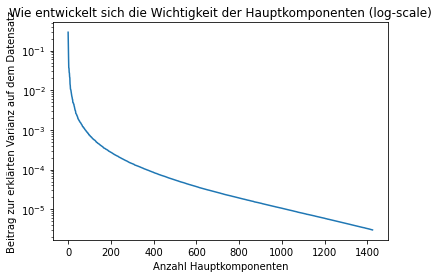

[0.28998233 0.40276959 0.46987467 0.50664861 0.54279088 0.57097607
 0.59816291 0.61986312 0.64058195 0.65492034 0.66807194 0.67873057
 0.68922771 0.69922623 0.70840752 0.71662998 0.72403384 0.73121946
 0.73811384 0.7445972  0.75052872 0.75636809 0.76134518 0.76622993
 0.77108855 0.77574313 0.7802194  0.78464612 0.78866881 0.79258901
 0.7962368  0.79958727 0.80283595 0.80594669 0.80903042 0.81192532
 0.81454329 0.8171189  0.81965877 0.82214293 0.82456422 0.82686144
 0.82913081 0.83136097 0.83346946 0.83554401 0.83746537 0.83937024
 0.84121788 0.84303825 0.84482975 0.84655694 0.84826982 0.84996365
 0.85158201 0.8531728  0.85473815 0.85628736 0.85782333 0.85931202
 0.86077583 0.86220212 0.86360895 0.86498233 0.86633202 0.86766252
 0.86894206 0.87018947 0.87140225 0.87261232 0.87380641 0.87499434
 0.87613438 0.8772591  0.87838073 0.8794893  0.88059014 0.88164538
 0.8826815  0.88370098 0.88469487 0.8856843  0.88666138 0.88763086
 0.88856847 0.8894965  0.89041462 0.89131096 0.89219326 0.8930

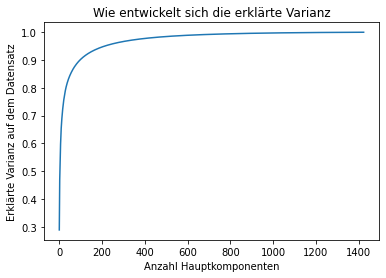

CPU times: user 3min 51s, sys: 7.87 s, total: 3min 59s
Wall time: 44.2 s


In [5]:
%%time

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pca = Pipeline([
    ('std', StandardScaler()), # Für PCA sollte man die Achsen standardisieren
    ('pca', PCA(n_components=0.999).fit(X_train.reshape(-1, 32 * 32 * 3)))
])

plt.title("Wie entwickelt sich die Wichtigkeit der Hauptkomponenten (log-scale)")
plt.plot(pca['pca'].explained_variance_ratio_)
plt.yscale('log')
plt.xlabel("Anzahl Hauptkomponenten")
plt.ylabel("Beitrag zur erklärten Varianz auf dem Datensatz")
plt.show()

import numpy as np

with np.printoptions(threshold=np.inf):
    print(np.cumsum(pca['pca'].explained_variance_ratio_[:100]))

plt.title("Wie entwickelt sich die erklärte Varianz")
plt.plot(np.cumsum(pca['pca'].explained_variance_ratio_))
plt.xlabel("Anzahl Hauptkomponenten")
plt.ylabel("Erklärte Varianz auf dem Datensatz")
plt.show()

In [6]:
def scale_between_1_and_0(X):
  return (X - np.min(X)) / (np.max(X) - np.min(X))

In [7]:
%%time

pca = Pipeline([
    ('std', StandardScaler()),
    ('pca', PCA(n_components=100))
]).fit(X_train.reshape(-1, 32 * 32 * 3))

print(X_train.reshape(-1, 32 * 32 * 3).shape)
print(pca.transform(X_train.reshape(-1, 32 * 32 * 3)).shape)
n_components_90 = pca['pca'].n_components_

print("100 with " + str(np.sum(pca['pca'].explained_variance_ratio_)) + "% Varianz explained")

(37500, 3072)
(37500, 100)
100 with 0.8983942780136469% Varianz explained
CPU times: user 43.7 s, sys: 4.95 s, total: 48.6 s
Wall time: 10.4 s


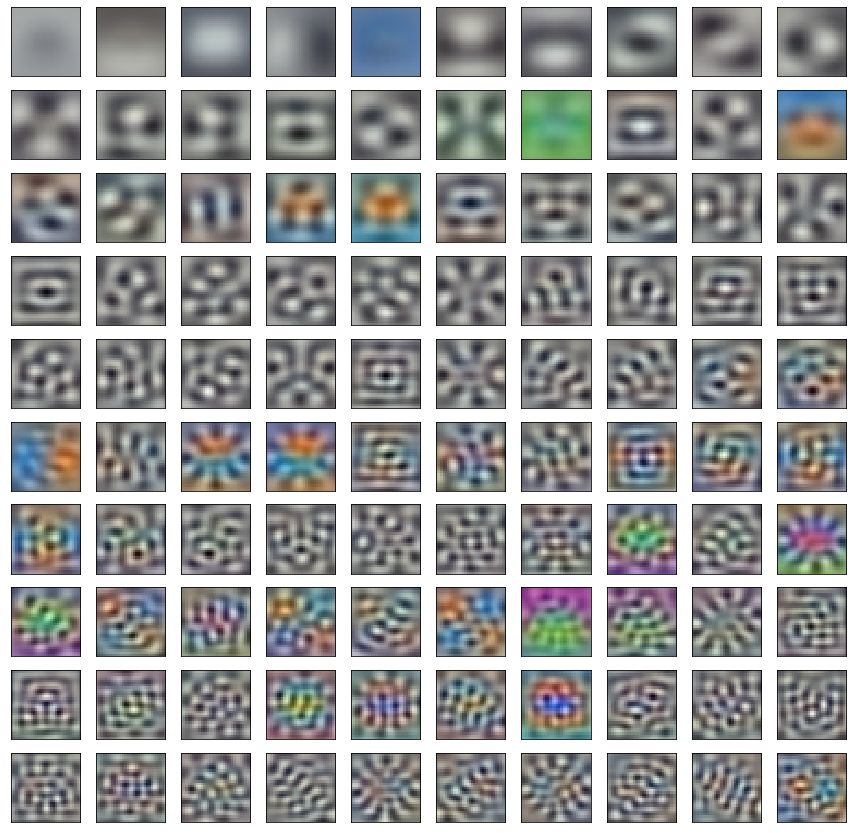

In [8]:
plot_image_grid(scale_between_1_and_0(pca['pca'].components_))

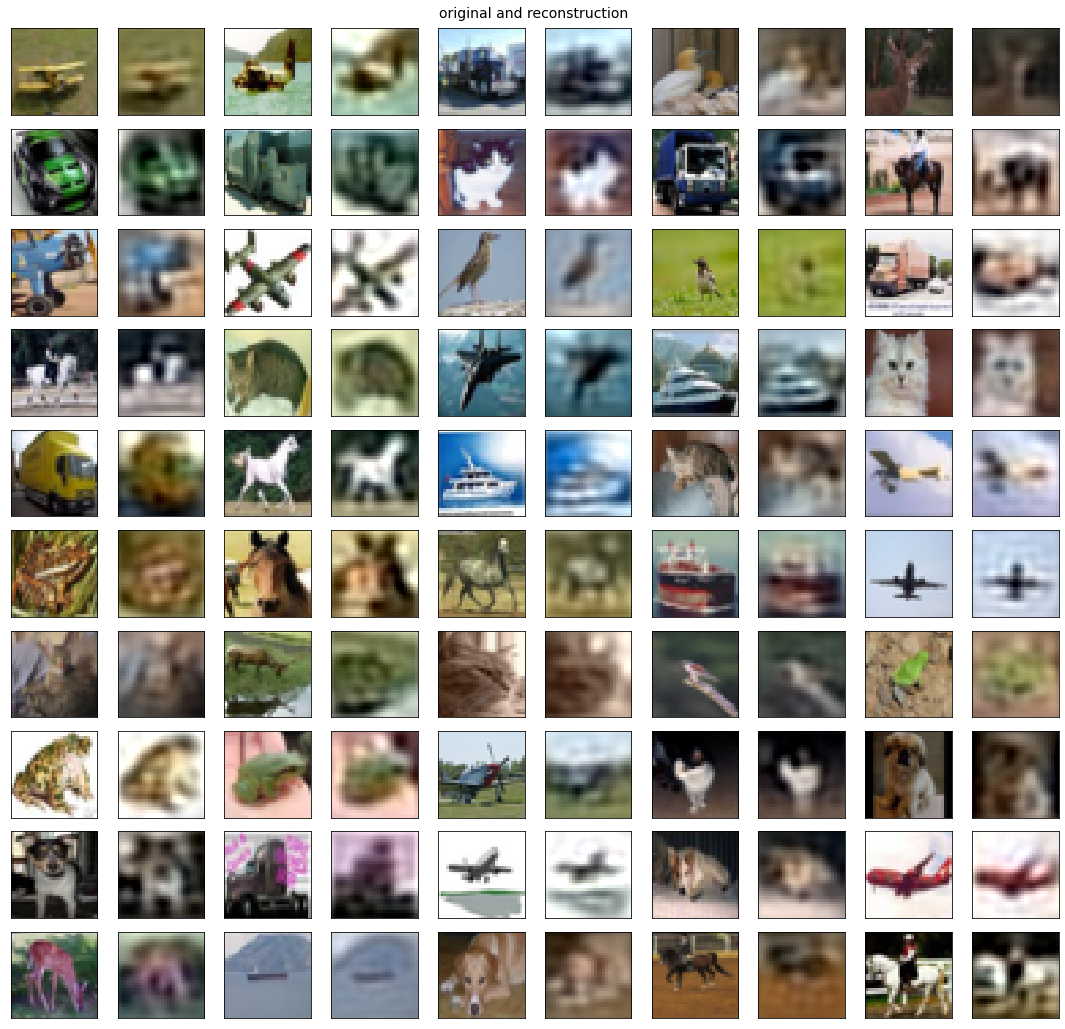

In [9]:
# Calculate reconstructions of PCA by transforming and inverse transforming.
X_train_reconstructed = pca.inverse_transform(pca.transform(X_train.reshape(-1, 32 * 32 * 3)))

# Ensure values are in valid (image) range of 0 and 255
X_train_reconstructed = np.clip(X_train_reconstructed, 0, 255).astype(int)

plot_image_grid(
    np.hstack([X_train.reshape(-1, 32 * 32 * 3), X_train_reconstructed]).reshape((-1, 32 * 32 * 3)),
    N=10,
    title="original and reconstruction"
)
plt.show()

### Logistic Regression with PCA

In [13]:
%%time

pca_lr = Pipeline([
    ('std', StandardScaler()),
    ('pca', PCA(n_components=200)),
    ('clf', LogisticRegression(max_iter=1000))
])

pca_lr.fit(X_train.reshape(-1, 32 * 32 * 3), y_train)

print("Anzahl Iterationen", pca_lr['clf'].n_iter_)

y_train_hat = pca_lr.predict(X_train.reshape(-1, 32 * 32 * 3))
print("Train: ", accuracy_score(y_train_hat, y_train))

y_val_hat = pca_lr.predict(X_val.reshape(-1, 32 * 32 * 3))
print("Val:   ", accuracy_score(y_val_hat, y_val))

Anzahl Iterationen [227]
Train:  0.4244266666666667
Val:    0.4124
CPU times: user 1min 32s, sys: 8.52 s, total: 1min 41s
Wall time: 19.7 s
